# Projet final du Kit Data Science 2021
Le projet final du Kit Data Science 2021 porte sur les données du *Vendée Globe 2020-2021*.

Le projet se déroule *26 octobre au 5 novembre 2021* date limite pour rendre vos projets respectifs.

Les données du dernier Vendée Globe sont disponibles sous la forme de fichiers Excel avec les classements fournis plusieurs fois par jour par les organisateurs de la course. Il y a également une page web avec une fiche technique par voilier qui contient des informations techniques et qu'il est possible de rapprocher des classements.

Il vous appartient de charger les données en Python, de procéder aux préparations nécessaires et d'effectuer les analyses pertinentes de votre choix.

Le rendu sera un notebook Jupyter fourni aux formats ipynb et HTML.

*Analyses qui seront effectuées*:

- Récupération des fichiers Excel avec les classements
  1. Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
  2. Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
- Extraction des caractéristiques techniques de chacun des voiliers.
- Rapprochement des données des voiliers avec celle des classements.
- Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
- Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
- Visualisation de la distance parcourue par voilier.
- Cartes avec les routes d'un ou plusieurs voiliers.
- Analyses de séries temporelles.
- Application d'algorithmes statistiques ou de machine learning.
- etc.

*Sources des données*

- Page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement
- Page web avec les fiches techniques des voiliers du Vendée Globe : https://www.vendeeglobe.org/fr/glossaire
- Site web donnant accès à des fichiers avec les formes géométriques des côtes : https://www.naturalearthdata.com/ (ou bien utilisez les librairies plotly ou ipyleaflet pour produire des cartes)
- etc.

*Questions/Réponses*

Les questions et réponses seront publiées ci-après au fil de l'eau :

1. Qu'est-ce qu'un foil ? https://www.vendeeglobe.org/fr/actualites/19755/quels-foils-pour-gagner-le-vendee-globe La présence d'un foil est indiqué dans l'attribut "Nombre de dérives" dans les fiches techniques des voiliers.
2. S'agit-il d'un travail individuel ou collectif ? Il s'agit bien d'un travail individuel.
3. Est-il possible de rendre plusieurs notebooks afin de délimiter clairement les différentes étapes du projet ? Tout peut tenir dans un seul notebook mais pourquoi pas.

## **1) importation des données :**

 Librairies utiles ...

In [110]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import requests 
import urllib.request
from bs4 import BeautifulSoup
import glob
import locale
locale.setlocale(locale.LC_ALL, 'fr_FR')
import seaborn as sns
import os
import win32com.client 
import re
from scipy import stats
from ipyleaflet import Map,Icon, Polyline,Popup,Marker,AwesomeIcon
from ipywidgets import HTML,Layout

1 -a) on ecrit la fonction qui permet de telecharger les fichiers..... et les mettre dans un dossier 'doc_excel'

In [30]:
def fonct_load():
    ## On va proceder par un percing du siteweb : on utilisera le tag qui contient tous les fichiers ...
    site = requests.get("https://www.vendeeglobe.org/fr/classement/3") ## Sans le chiffre juste avant, le percing renvois une erreur '404'...
    ## Recuperons le contenu du site qui nous interesse ......
    content = site.content.decode('utf-8')
    soup = BeautifulSoup(content)
    list_elements = soup.find ("select" , attrs = {"class":"form__input m--select onsubmit-rank"}).findAll("option")[1:] 
    
    for elements in list_elements :
        link ='https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+elements.attrs['value']+'.xlsx' 
        ## on enregistre chaque fichier telecharger à l'aide du lien ci dessus....
        urllib.request.urlretrieve(link , 'doc_excel/'+link.split('/')[-1])
       

In [6]:
fonct_load()

1-b) Losqu'on essaye de lire les fichiers avec pandas, ça ne marche pas, ce pendant, en essayant d'ouvrir et enregistrer à nouveau, là on peut lire avec pandas. on va donc essayé d'ouvri tous les fichiers là on peut lire avec pandas. on va donc essayé d'ouvrir tous les fichiers, et les enregistrer à nouveau avant de les ouvrir avec pandas. 
pour celà, on ecris la fonction update ci dessous.

In [8]:
def update():
    ## On definie l'appli que nous utiliserons avec win32 ...
    objet = win32com.client.Dispatch("Excel.Application")
    objet.Visible = False
    for element in os.listdir('doc_excel'):
        fichier = element.split(".")[0]
        c = os. getcwd()
        opened = objet.Workbooks.Open(c +'\\doc_excel\\'+ fichier)
        opened.ActiveSheet.SaveAs(c +'\\save_file\\'+ fichier +".xlsx")
        objet.Application.Quit()

In [9]:
update()

1-c) on souhaite creer un seul dataFrame à l'aide de tous les fichiers excels qu'on possède.....les features vides ne sont pas considerées ..

In [7]:
def all_df():
    names =pd.MultiIndex.from_tuples((('Rang',''),('Nat./Voile',''),('Skipper/Bateau',''),('Heure FR',''),('Latitude',''),('Longitude',''),('Depuis 30 minutes','Cap'),('Depuis 30 minutes','Vitesse'),('Depuis 30 minutes','VMG'),('Depuis 30 minutes','Distance'),('Depuis le dernier classement','Cap'),('Depuis le dernier classement','Vitesse'),('Depuis le dernier classement','VMG'),('Depuis le dernier classement','Distance'),('Depuis 24 heures','Cap'),('Depuis 24 heures','Vitesse'),('Depuis 24 heures','VMG'),('Depuis 24 heures','Distance'),('DTF',''),('DTL','')))
    all_file = glob.glob('save_file/*')
    df = pd.DataFrame()
    list_file = list(filter(lambda x: '20201108_140000' <= x[-20:-5] <= '20210127_140000', all_file))
    
### On parcours les fichiers dans de la liste list_file  et on lit avec pandas
    for elements in list_file: 
        df1 = pd.read_excel(elements ,'fr',header = [3,4], skiprows = range(38, 45))
        df1 = df1.iloc[:,1:]
        df1.columns = names
        df1["Date"] = elements[-20:-5]
        df = df.append(df1, ignore_index = True)
    return df

In [8]:
df = all_df()
df.head()

Rang Nat./Voile                                     Skipper/Bateau  \
                                                                       
0    1   \nFRA 18                      Louis Burton\nBureau Vallée 2   
1    2   \nMON 10  Boris Herrmann\nSeaexplorer - Yacht Club De Mo...   
2    3    \nFRA 8                              Jérémie Beyou\nCharal   
3    4   \nFRA 59                           Thomas Ruyant\nLinkedOut   
4    5   \nFRA 53                      Maxime Sorel\nV And B Mayenne   

         Heure FR    Latitude   Longitude Depuis 30 minutes            \
                                                        Cap   Vitesse   
0      15:30 FR\n  46°24.46'N  01°50.48'W              241°  17.7 kts   
1  15:31 FR\n1min  46°24.34'N  01°49.82'W              241°  11.1 kts   
2      15:30 FR\n  46°24.91'N  01°49.99'W              244°  15.5 kts   
3      15:30 FR\n  46°24.71'N  01°49.68'W              244°  13.2 kts   
4      15:30 FR\n  46°24.59'N  01°49.56'W              246°  10.9 kts   

                      ... Depuis le dernier classement                      \
        VMG Distance  ...                      Vitesse      VMG   Distance   
0  17.5 kts   0.3 nm  ...                      0.0 kts  0.0 kts  2788.0 nm   
1  10.9 kts   0.4 nm  ...                      0.0 kts  0.0 kts  2787.9 nm   
2  15.5 kts   0.5 nm  ...                      0.0 kts  0.0 kts  2788.5 nm   
3  13.1 kts   0.7 nm  ...                      0.0 kts  0.0 kts  2788.3 nm   
4  10.9 kts   0.2 nm  ...                      0.0 kts  0.0 kts  2788.1 nm   

  Depuis 24 heures                                    DTF     DTL  \
               Cap  Vitesse      VMG Distance                       
0             201°  0.3 kts  0.3 kts   6.1 nm  24293.9 nm  0.0 nm   
1             196°  0.3 kts  0.2 kts   6.0 nm  24294.2 nm  0.4 nm   
2             199°  0.2 kts  0.2 kts   5.5 nm  24294.3 nm  0.5 nm   
3             196°  0.2 kts  0.2 kts   5.6 nm  24294.5 nm  0.6 nm   
4             195°  0.8 kts  0.7 kts   5.8 nm  24294.5 nm  0.6 nm   

              Date  
                    
0  20201108_140000  
1  20201108_140000  
2  20201108_140000  
3  20201108_140000  
4  20201108_140000  

[5 rows x 21 columns]

1-d) On obtinet de dataFrame ci dessus .....Quelques infos sur le dataFrame en question

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15906 entries, 0 to 15905
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Rang, )                                  15906 non-null  object
 1   (Nat./Voile, )                            15906 non-null  object
 2   (Skipper/Bateau, )                        15906 non-null  object
 3   (Heure FR, )                              13703 non-null  object
 4   (Latitude, )                              13703 non-null  object
 5   (Longitude, )                             13703 non-null  object
 6   (Depuis 30 minutes, Cap)                  13703 non-null  object
 7   (Depuis 30 minutes, Vitesse)              13703 non-null  object
 8   (Depuis 30 minutes, VMG)                  13703 non-null  object
 9   (Depuis 30 minutes, Distance)             13703 non-null  object
 10  (Depuis le dernier classement, Cap)       1370

## **2) Phase de nettoyage du DataFrame precedement obtenu ...**

Pour le netoyage , on prendra chaque colonne et on transforme au bon type ('int' , 'float',....) on mettra à jour le nom des colonnes s il le faut , enlever des données manquantes,etc

In [31]:
### Cette fonction permettra de mettre à jour la latitude et la longitude ...
def coordinate(value):
    directions = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    result = value.replace(u'°',' ').replace('\'',' ').replace('.',' ')
    result = result.split()
    direction = result.pop()
    result.extend([0,0,0])
    return (int(result[0])+int(result[1])/60.0+int(result[2])/3600.0) * directions[direction]

In [13]:
df=df.copy()
df=df[(df['Rang']!='RET') & (df['Rang']!='NL')]
df['Rang']=df['Rang'].astype(int)
df['Nat./Voile']=df.loc[:,'Nat./Voile'].str.replace('\n','')
df['Nat./Voile'].value_counts().sort_index()
df.loc[df['Nat./Voile']=='FRFRA 02','Nat./Voile']='FRA 02'
df.loc[df['Nat./Voile']=='FRFRA 69','Nat./Voile']='FRA 69'
df['Id voile']=df['Nat./Voile'].str.extract('[a-zA-Z]+ (\d+)')[0].astype(int)

df[['Skipper','Bateau']]  =df['Skipper/Bateau'].str.extract('(.*)\n(.*)')
df=df.drop('Skipper/Bateau',axis=1,level=0)
df['Bateau']= df['Bateau'].apply(lambda x: 'Hugo Boss' if str(x)=='HUGO BOSS' else x )
#mise en forme de l'heure
var=df['Heure FR'].str.extract('(.*) FR\n(\d*\w*)')
var[1]=var[1].apply(lambda x: '0min' if x=='' else x)
df['Heure FR'] = (pd.to_datetime(var[0]+':00',format='%H:%M:%S')-pd.to_timedelta(var[1]) ).dt.strftime('%H:%M:%S')
# DTF et DTL
df['DTF']= df['DTF'].str.extract('(.*) nm').astype(float)[0]
df['DTL']= df['DTL'].str.extract('(.*) nm').astype(float)[0]

# distance et VGM
df[('Depuis 30 minutes','Distance')]= df[('Depuis 30 minutes','Distance')].str.extract('(\d+.?\d*)\s?\w*').astype(float)
df[('Depuis le dernier classement','Distance')]= df[('Depuis le dernier classement','Distance')].str.extract('(\d+.?\d*)\s?\w*').astype(float)
df[('Depuis 24 heures','Distance')]= df[('Depuis 24 heures','Distance')].str.extract('(\d+.?\d*)\s?\w*').astype(float)
df[('Depuis 30 minutes','VMG')]= df[('Depuis 30 minutes','VMG')].str.extract('(.*) kts').astype(float)
df[('Depuis le dernier classement','VMG')]= df[('Depuis le dernier classement','VMG')].str.extract('(.*) kts').astype(float)
df[('Depuis 24 heures','VMG')]= df[('Depuis 24 heures','VMG')].str.extract('(.*) kts').astype(float)

## cap et vitesse
df[('Depuis 30 minutes','Vitesse')]= df[('Depuis 30 minutes','Vitesse')].str.extract('(.*) kts').astype(float)
df[('Depuis le dernier classement','Vitesse')]= df[('Depuis le dernier classement','Vitesse')].str.extract('(.*) kts').astype(float)
df[('Depuis 24 heures','Vitesse')]= df[('Depuis 24 heures','Vitesse')].str.extract('(.*) kts').astype(float)
df[('Depuis 30 minutes','Cap')]= df[('Depuis 30 minutes','Cap')].str[:-1].astype(int)
df[('Depuis le dernier classement','Cap')]= df[('Depuis le dernier classement','Cap')].str[:-1].astype(int)
df[('Depuis 24 heures','Cap')]= df[('Depuis 24 heures','Cap')].str[:-1].astype(int)

## colonne date
df['Date']=pd.to_datetime(df['Date'], format="%Y%m%d_%H%M%S")
df.set_index(df['Date'], drop=True, inplace=True)
df=df.drop('Date',axis=1,level=0)
df.index.rename('Date classement', inplace=True)

#convertion de latitude et longitude 
df[['Latitude','Longitude']]=df[['Latitude','Longitude']].applymap(coordinate)

In [14]:
## Voci le dataFrame propre obtenu ....
df

Rang Nat./Voile  Heure FR   Latitude  Longitude  \
                                                                      
Date classement                                                       
2020-11-08 14:00:00    1     FRA 18  15:30:00  46.412778  -1.846667   
2020-11-08 14:00:00    2     MON 10  15:30:00  46.409444  -1.839444   
2020-11-08 14:00:00    3      FRA 8  15:30:00  46.425278  -1.844167   
2020-11-08 14:00:00    4     FRA 59  15:30:00  46.419722  -1.835556   
2020-11-08 14:00:00    5     FRA 53  15:30:00  46.416389  -1.832222   
...                  ...        ...       ...        ...        ...   
2021-01-27 14:00:00   21     FRA 71  14:30:00 -24.011667 -26.806389   
2021-01-27 14:00:00   22     FRA 50  14:30:00 -26.187778 -26.041944   
2021-01-27 14:00:00   23     FRA 83  14:30:00 -26.001944 -29.507500   
2021-01-27 14:00:00   24     FRA 72  14:30:00 -48.151389 -53.862500   
2021-01-27 14:00:00   25    FIN 222  14:30:00 -49.383611 -52.491389   

                    Depuis 30 minutes                         \
                                  Cap Vitesse   VMG Distance   
Date classement                                                
2020-11-08 14:00:00               241    17.7  17.5      0.3   
2020-11-08 14:00:00               241    11.1  10.9      0.4   
2020-11-08 14:00:00               244    15.5  15.5      0.5   
2020-11-08 14:00:00               244    13.2  13.1      0.7   
2020-11-08 14:00:00               246    10.9  10.9      0.2   
...                               ...     ...   ...      ...   
2021-01-27 14:00:00               347     8.9   7.9      4.4   
2021-01-27 14:00:00               348    10.9   9.9      5.4   
2021-01-27 14:00:00                 7    11.0  10.9      5.5   
2021-01-27 14:00:00                25    10.1  10.0      5.0   
2021-01-27 14:00:00                44     9.4   9.2      4.7   

                    Depuis le dernier classement  ...           \
                                             Cap  ... Distance   
Date classement                                   ...            
2020-11-08 14:00:00                          357  ...   2788.0   
2020-11-08 14:00:00                          357  ...   2787.9   
2020-11-08 14:00:00                          357  ...   2788.5   
2020-11-08 14:00:00                          357  ...   2788.3   
2020-11-08 14:00:00                          357  ...   2788.1   
...                                          ...  ...      ...   
2021-01-27 14:00:00                          355  ...     41.1   
2021-01-27 14:00:00                          349  ...     35.5   
2021-01-27 14:00:00                            1  ...     30.3   
2021-01-27 14:00:00                           23  ...     27.3   
2021-01-27 14:00:00                           38  ...     32.5   

                    Depuis 24 heures                             DTF     DTL  \
                                 Cap Vitesse   VMG Distance                    
Date classement                                                                
2020-11-08 14:00:00              201     0.3   0.3      6.1  24293.9     0.0   
2020-11-08 14:00:00              196     0.3   0.2      6.0  24294.2     0.4   
2020-11-08 14:00:00              199     0.2   0.2      5.5  24294.3     0.5   
2020-11-08 14:00:00              196     0.2   0.2      5.6  24294.5     0.6   
2020-11-08 14:00:00              195     0.8   0.7      5.8  24294.5     0.6   
...                              ...     ...   ...      ...      ...     ...   
2021-01-27 14:00:00              351    12.9  12.0    310.4   4521.7  4441.2   
2021-01-27 14:00:00              352    10.5   9.8    252.0   4639.1  4558.6   
2021-01-27 14:00:00              340     9.6   7.9    230.4   4674.6  4594.1   
2021-01-27 14:00:00               29    11.4  11.4    273.7   6341.5  6260.9   
2021-01-27 14:00:00               35    11.5  11.5    275.8   6376.7  6296.1   

                    Id voile         Skipper  \
                                  

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13703 entries, 2020-11-08 14:00:00 to 2021-01-27 14:00:00
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   (Rang, )                                  13703 non-null  int32  
 1   (Nat./Voile, )                            13703 non-null  object 
 2   (Heure FR, )                              13703 non-null  object 
 3   (Latitude, )                              13703 non-null  float64
 4   (Longitude, )                             13703 non-null  float64
 5   (Depuis 30 minutes, Cap)                  13703 non-null  int32  
 6   (Depuis 30 minutes, Vitesse)              13703 non-null  float64
 7   (Depuis 30 minutes, VMG)                  13703 non-null  float64
 8   (Depuis 30 minutes, Distance)             13703 non-null  float64
 9   (Depuis le dernier classement, Cap)       13703 non-null  int32  
 10 

## **3) Telechargement des valeurs Techniques ....**

In [111]:
## On utilise le meme principe que precedement : un percing 
site_ = requests.get("https://www.vendeeglobe.org/fr/glossaire")
content = site_.content.decode('utf-8')
soup_objet = BeautifulSoup(content)
all_car=[]
liste_cont = soup_objet.findAll("div" , attrs={"class":"sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6"}) 
for element in liste_cont:
    objet = {item.text.split(':')[0].strip():item.text.split(':')[1].strip() for item in element.findAll('li')}
    objet['Lien image']=element.find('img').attrs['src']
    objet['Nom voilier']=element.find('h3', attrs={'class':'boats-list__boat-name'}).text
    objet['Nom skipper']=element.find('span', attrs={'class':'boats-list__skipper-name'}).text
    all_car.append(objet)
df2 =pd.DataFrame(all_car)

In [18]:
##le dataFrame ci dessous est obtenu...
df2

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Lien image,Nom voilier,Nom skipper
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2,/medias/05/08/50821/image-r-0-280.png,NEWREST - ART & FENÊTRES,Fabrice AMEDEO
1,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2,/medias/05/06/50663/image-r-0-280.png,PURE - Best Western®,Romain ATTANASIO
2,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2,/medias/05/04/50477/image-r-0-280.png,TSE - 4MYPLANET,Alexia BARRIER
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2,/medias/05/08/50815/image-r-0-280.png,Maître CoQ IV,Yannick BESTAVEN
4,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2,/medias/05/04/50486/image-r-0-280.png,CHARAL,Jérémie BEYOU
5,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²,/medias/05/04/50498/image-r-0-280.png,LA MIE CÂLINE - ARTISANS ARTIPÔLE,Arnaud BOISSIÈRES
6,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2,/medias/05/04/50485/image-r-0-280.png,BUREAU VALLEE 2,Louis BURTON
7,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,02 Février 2000,"18,28 m","5,30 m","4,50 m","8,9 t",2,26 m,acier,240 m2,470 m2,/medias/00/00/0/image-r-0-280.jpg,ONE PLANET ONE OCEAN,Didac COSTA
8,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,"18,28 m","5,80 m","4,50 m",9 t,2 asymétriques,"28,50",basculante sur vérin hydraulique,270 m2,560 m2,/medias/05/04/50490/image-r-0-280.png,GROUPE SÉTIN,Manuel COUSIN
9,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,"18,28 m","5,70 m","4,5 m","7,7 t",2,29 m,acier forgé,340 m2,570 m2,/medias/05/04/50484/image-r-0-280.png,BANQUE POPULAIRE X,Clarisse CREMER


In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Numéro de voile               32 non-null     object
 1   Anciens noms du bateau        24 non-null     object
 2   Architecte                    33 non-null     object
 3   Chantier                      33 non-null     object
 4   Date de lancement             33 non-null     object
 5   Longueur                      33 non-null     object
 6   Largeur                       33 non-null     object
 7   Tirant d'eau                  33 non-null     object
 8   Déplacement (poids)           33 non-null     object
 9   Nombre de dérives             33 non-null     object
 10  Hauteur mât                   33 non-null     object
 11  Voile quille                  32 non-null     object
 12  Surface de voiles au près     33 non-null     object
 13  Surface de voiles au p

## **4) Nettoyage du dataFrame technique...**

Meme principe que precedement, chaque colone est prise, actualisé comme il faut et on rajoute celle qui manque ....

In [21]:
#Le voile de numero NAN correspond à  FRA 59 Thomas Ruyant
df2.loc[df2['Numéro de voile'].isna(),'Numéro de voile']='FRA 59'
var=df2['Numéro de voile'].str.extract('([a-zA-Z]*)\s*(\d+)')
df2['Numéro de voile']=var[0]+' '+var[1]

df2['Id voile']=df2['Numéro de voile'].str.extract('[a-zA-Z]*\s*(\d+)')[0].astype(int)
#Nettoyage de Anciens noms du bateau

#Nettoyage de Date de lancement
df2['Date de lancement']=pd.to_datetime(df2['Date de lancement'], format="%d %B %Y")

#Nettoyage de Longueur , largeur , Tirant d'eau , Hauteur mât ,Surface de voiles au près,Surface de voiles au portant,Déplacement (poids)
df2['Longueur']=df2['Longueur'].str.extract('(\d+,*\d+)\s*m')[0].str.replace(',','.').astype(float)
df2['Largeur']=df2['Largeur'].str.extract('(\d+\,*\d+)\s*m')[0].str.replace(',','.').astype(float)
df2["Tirant d'eau"]=df2["Tirant d'eau"].str.extract('(\d+\,*\d+)\s*m')[0].str.replace(',','.').astype(float)
df2["Hauteur mât"]=df2["Hauteur mât"].str.extract('(\d+\,*\d+)\s*m?')[0].str.replace(',','.').astype(float)
df2["Surface de voiles au près"]=df2["Surface de voiles au près"].str.extract('(\d+)\s*.*')[0].astype(float)
df2["Surface de voiles au portant"]=df2["Surface de voiles au portant"].str.extract('(\d+)\s*.*')[0].astype(float)
df2["Déplacement (poids)"]=df2["Déplacement (poids)"].str.extract('(\d+\,*\d*)\s*.*')[0].str.replace(',','.').astype(float)

# suprimer les caractères invisibles 
# modification des differents nom ....
df2['Nom skipper']=df2['Nom skipper'].apply(lambda x: re.sub('\W+',' ',x).strip())
df2.loc[df2['Nom skipper']=='Arnaud BOISSIÈRES','Nom skipper']='Arnaud BOISSIERES'
df2.loc[df2['Nom skipper']=='Sam DAVIES','Nom skipper']='Samantha DAVIES'

In [22]:
## le dataFrame des caracteriques techniques nettoyé ci dessous ...
df2

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Lien image,Nom voilier,Nom skipper,Id voile
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015-08-01,18.28,5.85,4.5,7.0,foils,29.0,monotype,320.0,570.0,/medias/05/08/50821/image-r-0-280.png,NEWREST - ART & FENÊTRES,Fabrice AMEDEO,56
1,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007-03-08,18.28,5.80,4.5,9.0,2,28.0,acier forgé,280.0,560.0,/medias/05/06/50663/image-r-0-280.png,PURE - Best Western®,Romain ATTANASIO,49
2,FRA 72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-03-01,18.28,5.54,4.5,9.0,2,29.0,acier,260.0,580.0,/medias/05/04/50477/image-r-0-280.png,TSE - 4MYPLANET,Alexia BARRIER,72
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,2015-03-12,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0,/medias/05/08/50815/image-r-0-280.png,Maître CoQ IV,Yannick BESTAVEN,17
4,08,NaN,VPLP,CDK Technologies,2018-08-18,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0,/medias/05/04/50486/image-r-0-280.png,CHARAL,Jérémie BEYOU,8
5,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,2007-08-03,18.28,5.65,4.5,7.9,foils,29.0,basculante avec vérin,300.0,610.0,/medias/05/04/50498/image-r-0-280.png,LA MIE CÂLINE - ARTISANS ARTIPÔLE,Arnaud BOISSIERES,14
6,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,2015-06-09,18.28,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0,/medias/05/04/50485/image-r-0-280.png,BUREAU VALLEE 2,Louis BURTON,18
7,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,2000-02-02,18.28,5.30,4.5,8.9,2,26.0,acier,240.0,470.0,/medias/00/00/0/image-r-0-280.jpg,ONE PLANET ONE OCEAN,Didac COSTA,33
8,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),2007-02-02,18.28,5.80,4.5,9.0,2 asymétriques,28.5,basculante sur vérin hydraulique,270.0,560.0,/medias/05/04/50490/image-r-0-280.png,GROUPE SÉTIN,Manuel COUSIN,71
9,FRA 30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,2011-03-01,18.28,5.70,4.5,7.7,2,29.0,acier forgé,340.0,570.0,/medias/05/04/50484/image-r-0-280.png,BANQUE POPULAIRE X,Clarisse CREMER,30


## **5) Jointure des deux DataFrame**

On utilisera la fonction merge et on va utiliser le colonne " Nom skipper miniscule" comme colonne de jointure

In [24]:
df_int =df.reset_index()
df_int=df_int.droplevel(1, axis=1)
df_int['Nom skipper miniscule']=df_int['Skipper'].str.lower()
df2['Nom skipper miniscule']=df2['Nom skipper'].str.lower()
all_df=pd.merge(df_int,df2,left_on='Nom skipper miniscule',right_on='Nom skipper miniscule')
liste_colon =["Date classement","Rang","Nat./Voile","Heure FR","Latitude","Longitude",
    "Depuis 30 minutes - Cap","Depuis 30 minutes - Vitesse","Depuis 30 minutes - VMG","Depuis 30 minutes - Distance",
    "Depuis le dernier classement - Cap","Depuis le dernier classement - Vitesse","Depuis le dernier classement - VMG","Depuis le dernier classement - Distance",
    "Depuis 24 heures - Cap","Depuis 24 heures - Vitesse","Depuis 24 heures - VMG","Depuis 24 heures - Distance",
    "DTF","DTL","Id voile classement","Skipper","Bateau","Nom skipper miniscule","Numéro de voile","Anciens noms du bateau",
    "Architecte","Chantier","Date de lancement","Longueur voile","Largeur voile","Tirant d'eau voile","Déplacement (poids) voile",
    "Nombre de dérives voile","Hauteur mât voile","Voile quille","Surface de voiles au près","Surface de voiles au portant","Lien image voile","Nom voilier","Nom skipper","Id voile technique"]

all_df.columns=liste_colon

all_df.set_index('Date classement',inplace=True)

In [35]:
### all_df represente le dataFrame combinée ...
all_df.head()

,Rang,Nat./Voile,Heure FR,Latitude,Longitude,Depuis 30 minutes - Cap,Depuis 30 minutes - Vitesse,Depuis 30 minutes - VMG,Depuis 30 minutes - Distance,Depuis le dernier classement - Cap,...,Déplacement (poids) voile,Nombre de dérives voile,Hauteur mât voile,Voile quille,Surface de voiles au près,Surface de voiles au portant,Lien image voile,Nom voilier,Nom skipper,Id voile technique
Date classement,,,,,,,,,,,,,,,,,,,,,
2020-11-08 14:00:00,1,FRA 18,15:30:00,46.412778,-1.846667,241,17.7,17.5,0.3,357,...,7.6,foils,28.0,acier,300.0,600.0,/medias/05/04/50485/image-r-0-280.png,BUREAU VALLEE 2,Louis BURTON,18
2020-11-08 15:00:00,8,FRA 18,17:00:00,46.357500,-2.507222,269,20.9,18.0,10.5,263,...,7.6,foils,28.0,acier,300.0,600.0,/medias/05/04/50485/image-r-0-280.png,BUREAU VALLEE 2,Louis BURTON,18
2020-11-08 17:00:00,11,FRA 18,18:30:00,46.370278,-3.283889,271,20.3,16.4,10.2,271,...,7.6,foils,28.0,acier,300.0,600.0,/medias/05/04/50485/image-r-0-280.png,BUREAU VALLEE 2,Louis BURTON,18
2020-11-08 21:00:00,8,FRA 18,22:30:00,46.279722,-4.805278,262,12.3,10.1,6.2,265,...,7.6,foils,28.0,acier,300.0,600.0,/medias/05/04/50485/image-r-0-280.png,BUREAU VALLEE 2,Louis BURTON,18
2020-11-09 04:00:00,11,FRA 18,05:30:00,46.476667,-7.073333,294,13.9,0.4,6.9,276,...,7.6,foils,28.0,acier,300.0,600.0,/medias/05/04/50485/image-r-0-280.png,BUREAU VALLEE 2,Louis BURTON,18


In [27]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13703 entries, 2020-11-08 14:00:00 to 2021-01-27 14:00:00
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Rang                                     13703 non-null  int32         
 1   Nat./Voile                               13703 non-null  object        
 2   Heure FR                                 13703 non-null  object        
 3   Latitude                                 13703 non-null  float64       
 4   Longitude                                13703 non-null  float64       
 5   Depuis 30 minutes - Cap                  13703 non-null  int32         
 6   Depuis 30 minutes - Vitesse              13703 non-null  float64       
 7   Depuis 30 minutes - VMG                  13703 non-null  float64       
 8   Depuis 30 minutes - Distance             13703 non-null  float64       
 9   Depu

## **6) Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers**

On construit un DataFrame du rang et de la vitesse moyenne ....

In [38]:
df_regr = all_df[['Depuis 24 heures - VMG','Rang','Nat./Voile']].groupby(by='Nat./Voile' , dropna=True).agg({'Depuis 24 heures - VMG':'mean','Rang':'mean','Nat./Voile':'count'})
df_regr.columns= ["Speed","position",'Nombre classement']

df_regr= df_regr.loc[df_regr['Nombre classement']==df_regr['Nombre classement'].max()]

df_regr.head()

,Speed,position,Nombre classement
Nat./Voile,,,
ESP 33,10.643776,19.993776,482
FIN 222,9.253112,26.390041,482
FRA 01,12.343568,5.599585,482
FRA 02,12.086307,16.350622,482
FRA 09,12.292739,7.545643,482


regression et intervale à l'aide scipy calculer les elements statiques ....

C:\Users\Djouakep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


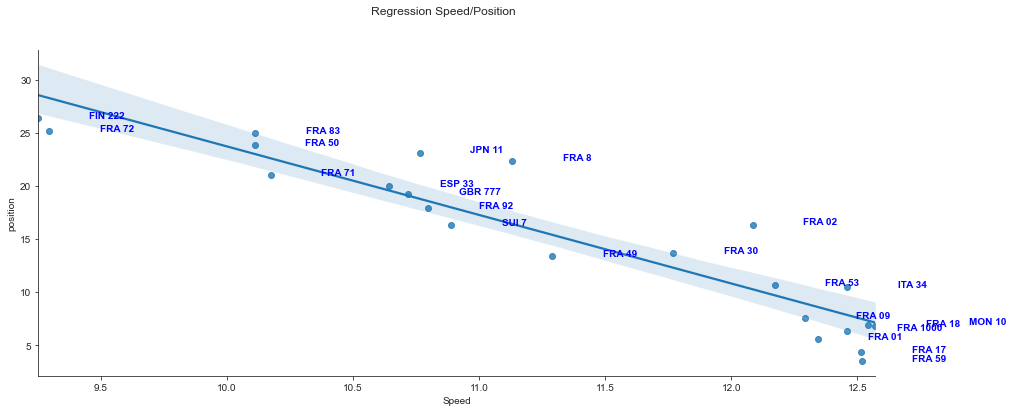

In [44]:
sns.set_style('ticks')
fig,ax = plt.subplots()
fig.set_size_inches(15, 6)
fig.suptitle('Regression Speed/Position')

sns.regplot(df_regr['Speed'], df_regr['position']);
sns.despine()
for nb in range(0, df_regr.shape[0]):
    if df_regr.index[nb] in ('MON 10',):
        plt.text(df_regr.iloc[nb,0]+0.4, df_regr.iloc[nb,1], df_regr.index[nb], horizontalalignment='left', size='medium', color='b', weight='semibold')
    else:
        plt.text(df_regr.iloc[nb,0]+0.2, df_regr.iloc[nb,1], df_regr.index[nb], horizontalalignment='left', size='medium', color='b', weight='semibold')

plt.show()

les caracteristiques de la regression ....

In [49]:
pente, intercept, value, p_value, se = stats.linregress(df_regr['Speed'], df_regr['position'])
print("La pente de la regression est : ", pente)
print("L'intercept est :", intercept)
print("La correlation est definie : ", abs (value))
print("La p_value : rejet ou accepter l'hypothèse H0", p_value)
print("La p_value etant très faible, l'hypothèse H0 n'est pas rejetter...")

La pente de la regression est :  -6.450894347750231
L'intercept est : 88.22429813790833
La correlation est definie :  0.9307632930014001
La p_value : rejet ou accepter l'hypothèse H0 1.2235996550878722e-10
La p_value etant très faible, l'hypothèse H0 n'est pas rejetter...


 qu'en est t'il de la regression de la vitesse utile - Rang ....

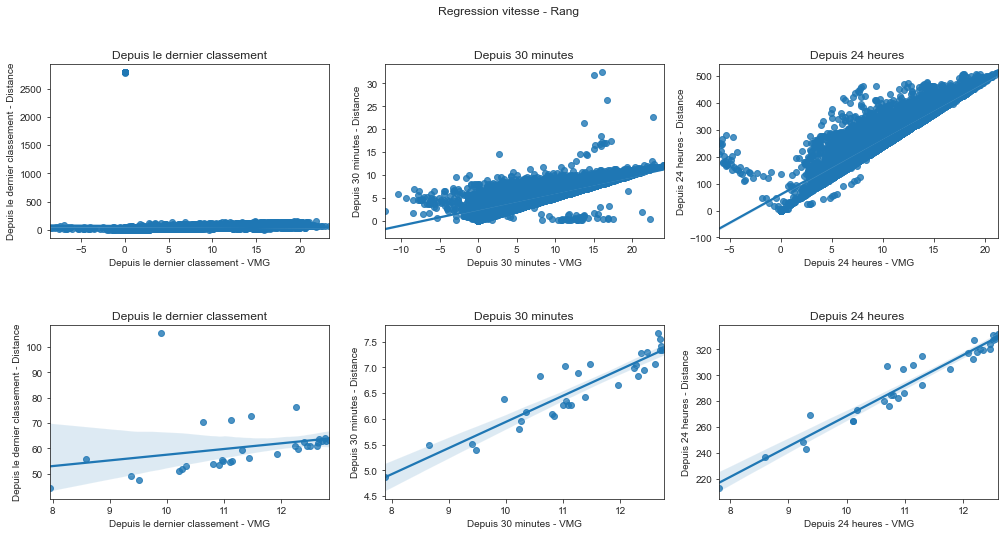

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(17,8)) 
fig.suptitle('Regression vitesse utile - Rang')
axes[0][0].set_title('Depuis le dernier classement')
axes[0][1].set_title('Depuis 30 minutes')
axes[0][2].set_title('Depuis 24 heures ')
fig.subplots_adjust(hspace=0.5) 

sns.regplot(ax=axes[0][0],x=all_df['Depuis le dernier classement - VMG'],y=all_df['Depuis le dernier classement - Distance']);
sns.regplot(ax=axes[0][1],x=all_df['Depuis 30 minutes - VMG'],y=all_df['Depuis 30 minutes - Distance']);
sns.regplot(ax=axes[0][2],x=all_df['Depuis 24 heures - VMG'],y=all_df['Depuis 24 heures - Distance']);

df_new= all_df[['Depuis le dernier classement - Distance','Depuis le dernier classement - VMG','Depuis 30 minutes - VMG','Depuis 30 minutes - Distance','Depuis 24 heures - Distance','Depuis 24 heures - VMG','Nat./Voile']].groupby(by='Nat./Voile' , dropna=True).mean()
axes[1][0].set_title('Depuis le dernier classement')
axes[1][1].set_title('Depuis 30 minutes')
axes[1][2].set_title('Depuis 24 heures ')
sns.regplot(ax=axes[1][0],x=df_new['Depuis le dernier classement - VMG'],y=df_new['Depuis le dernier classement - Distance']);
sns.regplot(ax=axes[1][1],x=df_new['Depuis 30 minutes - VMG'],y=df_new['Depuis 30 minutes - Distance']);
sns.regplot(ax=axes[1][2],x=df_new['Depuis 24 heures - VMG'],y=df_new['Depuis 24 heures - Distance']);

Une derniere regression avec la vitesse (vitesse utile - vitesse)

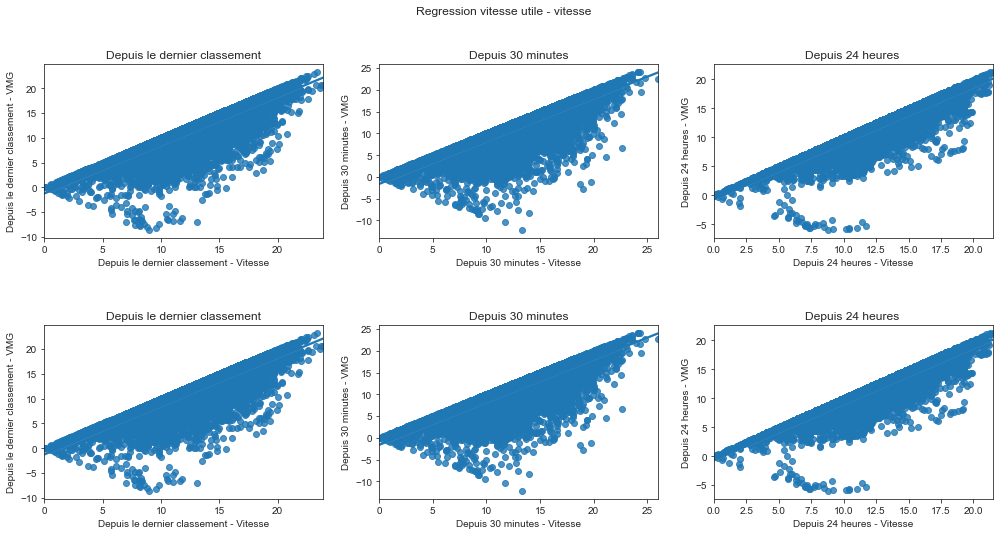

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(17,8)) 
fig.suptitle('Regression vitesse utile - vitesse')
axes[0][0].set_title('Depuis le dernier classement')
axes[0][1].set_title('Depuis 30 minutes')
axes[0][2].set_title('Depuis 24 heures ')
fig.subplots_adjust(hspace=0.5)  

sns.regplot(ax=axes[0][0],x=all_df['Depuis le dernier classement - Vitesse'], y=all_df['Depuis le dernier classement - VMG']);
sns.regplot(ax=axes[0][1],x=all_df['Depuis 30 minutes - Vitesse'], y=all_df['Depuis 30 minutes - VMG']);
sns.regplot(ax=axes[0][2],x=all_df['Depuis 24 heures - Vitesse'], y=all_df['Depuis 24 heures - VMG']);

#Cas de la moyenne
df_new1= all_df[['Depuis le dernier classement - Vitesse','Depuis le dernier classement - VMG','Depuis 30 minutes - VMG','Rang','Depuis 30 minutes - Vitesse','Depuis 24 heures - Vitesse','Depuis 24 heures - VMG','Nat./Voile']].groupby(by='Nat./Voile' , dropna=True).mean()
axes[1][0].set_title('Depuis le dernier classement')
axes[1][1].set_title('Depuis 30 minutes')
axes[1][2].set_title('Depuis 24 heures ')
sns.regplot(ax=axes[1][0],x=all_df['Depuis le dernier classement - Vitesse'], y=all_df['Depuis le dernier classement - VMG']);
sns.regplot(ax=axes[1][1],x=all_df['Depuis 30 minutes - Vitesse'], y=all_df['Depuis 30 minutes - VMG']);
sns.regplot(ax=axes[1][2],x=all_df['Depuis 24 heures - Vitesse'], y=all_df['Depuis 24 heures - VMG']);

Si on calculais les parametres pour les regressions vu precedement ......

In [ ]:
## parametre regression vitesse utile - Rang

In [59]:
pente, intercept, value, p_value, se = stats.linregress(all_df['Depuis le dernier classement - VMG'], all_df['Rang'])
print("La pente de la regression est : ", pente)
print("L'intercept est :", intercept)
print("La correlation est definie : ", abs (value))
print("La p_value : rejet ou accepter l'hypothèse H0", p_value)
print("La p_value etant très faible, l'hypothèse H0 n'est pas rejetter...")

La pente de la regression est :  -0.5852892770370857
L'intercept est : 21.52368704937299
La correlation est definie :  0.3028289189352652
La p_value : rejet ou accepter l'hypothèse H0 1.5290603554142814e-288
La p_value etant très faible, l'hypothèse H0 n'est pas rejetter...


### 7) Visualisiation de quelques elements ... 

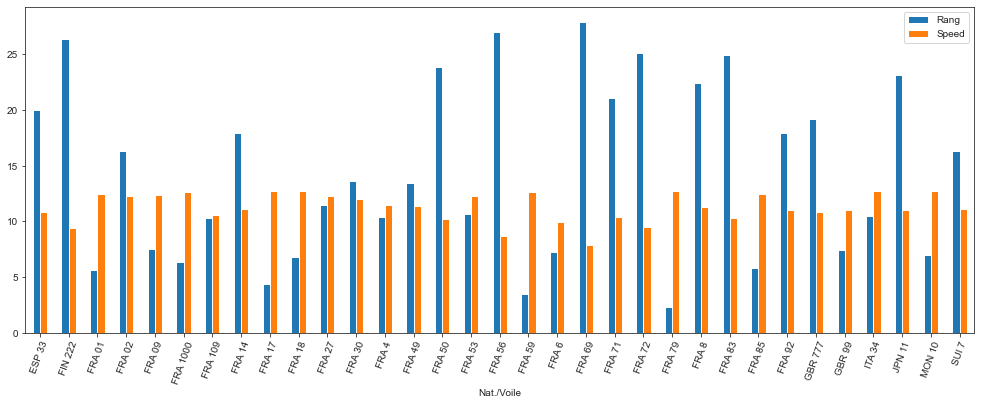

In [72]:
df_use =all_df[['Depuis 30 minutes - VMG','Rang','Nat./Voile']].groupby(by='Nat./Voile' , dropna=True).agg({'Depuis 30 minutes - VMG':'mean','Rang':'mean','Nat./Voile':'count'})
df_use.columns= ["Speed","Rang",'Nombre de classement']
df_use[['Rang','Speed']].plot(kind='bar', rot=70,figsize=(17, 6));

Dans la figure ci dessus, on visualise le rang et la vitesse .... On constate que on n'est pas forcement dans les cas des autres courses où plus la vitesse est grande, plus le rang est élevé ...

### 8) analyse sur l'impact d'un foil...

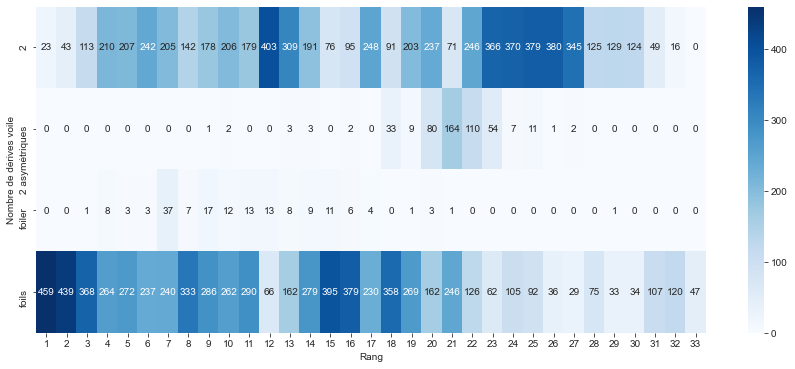

In [74]:
### Visualisation avec heatmap ...
df_heat=all_df[['Depuis le dernier classement - VMG','Rang','Nombre de dérives voile']]

fig, axes = plt.subplots(1, 1, figsize=(15,6)) 

tab = pd.crosstab(df_heat['Nombre de dérives voile'], df_heat['Rang'])
sns.heatmap(tab, cmap='Blues', annot=True, fmt='d');

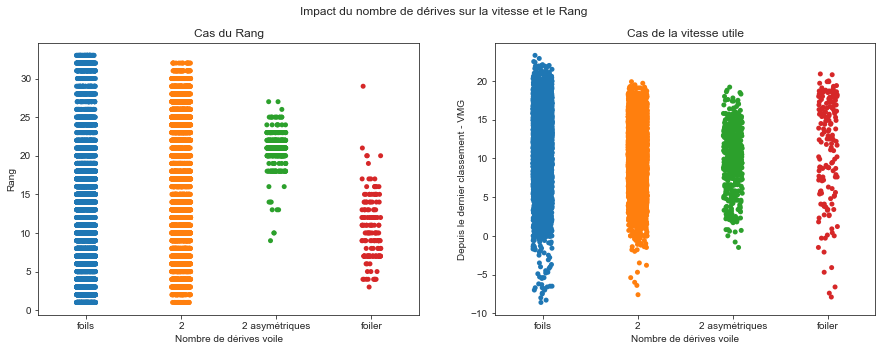

In [75]:
## utilisons un scatterplot
df_sc=all_df[['Depuis le dernier classement - VMG','Rang','Nombre de dérives voile']]

fig, axes = plt.subplots(1, 2, figsize=(15,5)) 
fig.suptitle('Impact du nombre de dérives sur la vitesse et le Rang')
axes[0].set_title('Cas du Rang')
axes[1].set_title('Cas de la vitesse utile')

sns.stripplot(ax=axes[0],data=df_sc, x='Nombre de dérives voile', y='Rang');
sns.stripplot(ax=axes[1],data=df_sc, x='Nombre de dérives voile', y='Depuis le dernier classement - VMG');

Le foil permet d'augmenter la vitesse utile..., ainsi les bateaux dotée d'un foil vont plus vite...

,Depuis le dernier classement - VMG,Rang,Nombre de dérives voile
Nombre de dérives voile,,,
2,10.977294,17.171101,2
2 asymétriques,10.325519,21.029046,2 asymétriques
foiler,11.474684,10.398734,foiler
foils,11.870329,12.415185,foils


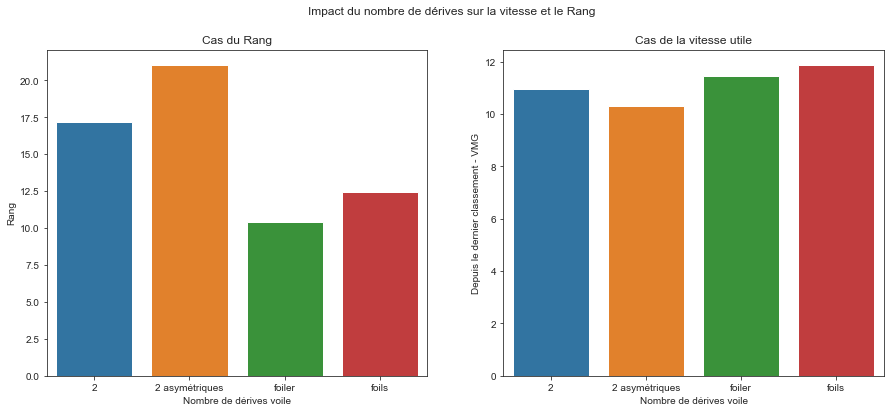

In [76]:
## visualisation en bar .... 
df_bar=all_df[['Depuis le dernier classement - VMG','Rang','Nombre de dérives voile']].groupby(by='Nombre de dérives voile' , dropna=True).agg({'Depuis le dernier classement - VMG':'mean','Rang':'mean','Nombre de dérives voile':'max'})

fig, axes = plt.subplots(1, 2, figsize=(15,6)) 
fig.suptitle('Impact du nombre de dérives sur la vitesse et le Rang')
axes[0].set_title('Cas du Rang')
axes[1].set_title('Cas de la vitesse utile')


sns.barplot(ax=axes[0],data=df_bar, x='Nombre de dérives voile', y='Rang', ci=None);
sns.barplot(ax=axes[1],data=df_bar, x='Nombre de dérives voile', y='Depuis le dernier classement - VMG', ci=None);

df_bar.head()

### Visualisation du rang des differents voilier .... 

Skipper,Alex Thomson,Alexia Barrier,Ari Huusela,Armel Tripon,Arnaud Boissieres,Benjamin Dutreux,Boris Herrmann,Charlie Dalin,Clarisse Cremer
Date classement,,,,,,,,,
2020-11-08 14:00:00,8.0,27.0,31.0,26.0,NaN,25.0,2.0,NaN,22.0
2020-11-08 15:00:00,3.0,28.0,32.0,10.0,NaN,24.0,5.0,2.0,22.0
2020-11-08 17:00:00,4.0,31.0,32.0,7.0,NaN,23.0,5.0,2.0,20.0
2020-11-08 21:00:00,6.0,32.0,30.0,3.0,28.0,21.0,7.0,5.0,20.0
2020-11-09 04:00:00,19.0,29.0,30.0,6.0,26.0,12.0,22.0,17.0,13.0


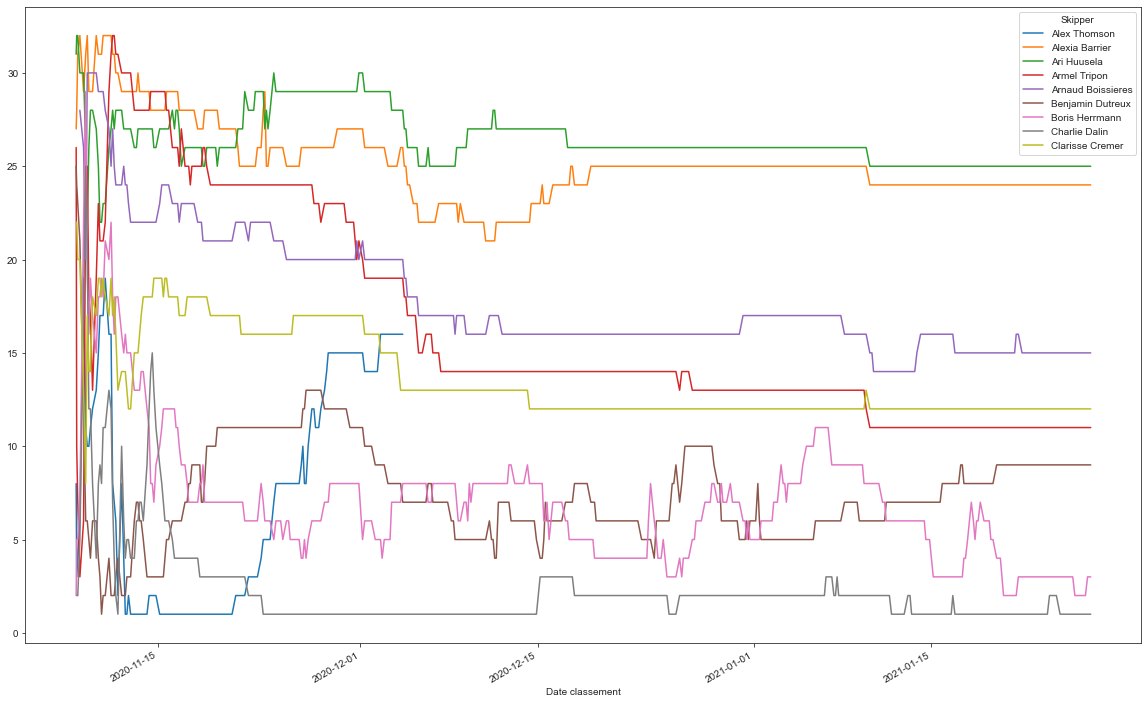

In [77]:
df_vis = all_df[['Rang','Skipper']]

df_vis=pd.pivot_table(df_vis,values='Rang',columns=['Skipper'],index=['Date classement'])
df_vis.iloc[:,1:10].plot(figsize=(20, 13));

df_vis.iloc[:,1:10].head()

differents Voiliers sur une carte ....... 

In [101]:
df_carte = all_df.loc[all_df['Nat./Voile'] =='FRA 79',['Latitude','Longitude']]
all_voil= all_df['Nat./Voile'].unique()
position= {}
for element in all_voil:
    position[element]=all_df.loc[all_df['Nat./Voile'] ==element,['Latitude','Longitude']].values.tolist()
    
couleurs =[ "yellow", "black", "orange", "white", "purple", "green", "blue","red"]
col=[]
for j in range(0,len(position)):
    col.append(couleurs[j%(len(couleurs))])


ways=[]
idx=0

for el in position:
    way = Polyline(locations=position[el],color=col[idx],fill=False,weight=1,opacity=0.5,dash_array='2, 2')
    ways.append(way)
    idx+=1

center = tuple(df_carte[['Latitude','Longitude']].mean()-[-20,1])
carte1 = Map( center=center, zoom=2)

for way in ways:
    carte1.add_layer(way)

depart =tuple(all_df[['Latitude','Longitude']].iloc[0])
depart_marker = Marker(location=depart, draggable=True,title='Depart')
carte1.add_layer(depart_marker)

df_first= all_df.loc[all_df['Nat./Voile']=='FRA 17',['Latitude','Longitude','Lien image voile']]
df_first= df_first.resample('W').last()
idx=0
for point in df_first.values.tolist():
    icon = Icon(icon_url='https://www.vendeeglobe.org'+point[-1], icon_size=[30, 40], icon_anchor=[22,30])
    title=df_first.index[idx].strftime("%m/%d/%Y %H:%M:%S")
    weekly_marker=Marker(location=point[0:2], draggable=True,alt=title,title=title,icon=icon)
   
    carte1.add_layer(weekly_marker)
    idx+=1
carte1.save('cartographie.html', title='image differents voilier')
carte1

Map(center=[-2.9675796950796816, -14.383581081081095], controls=(ZoomControl(options=['position', 'zoom_in_tex…

Ci dessous l'image en capture....
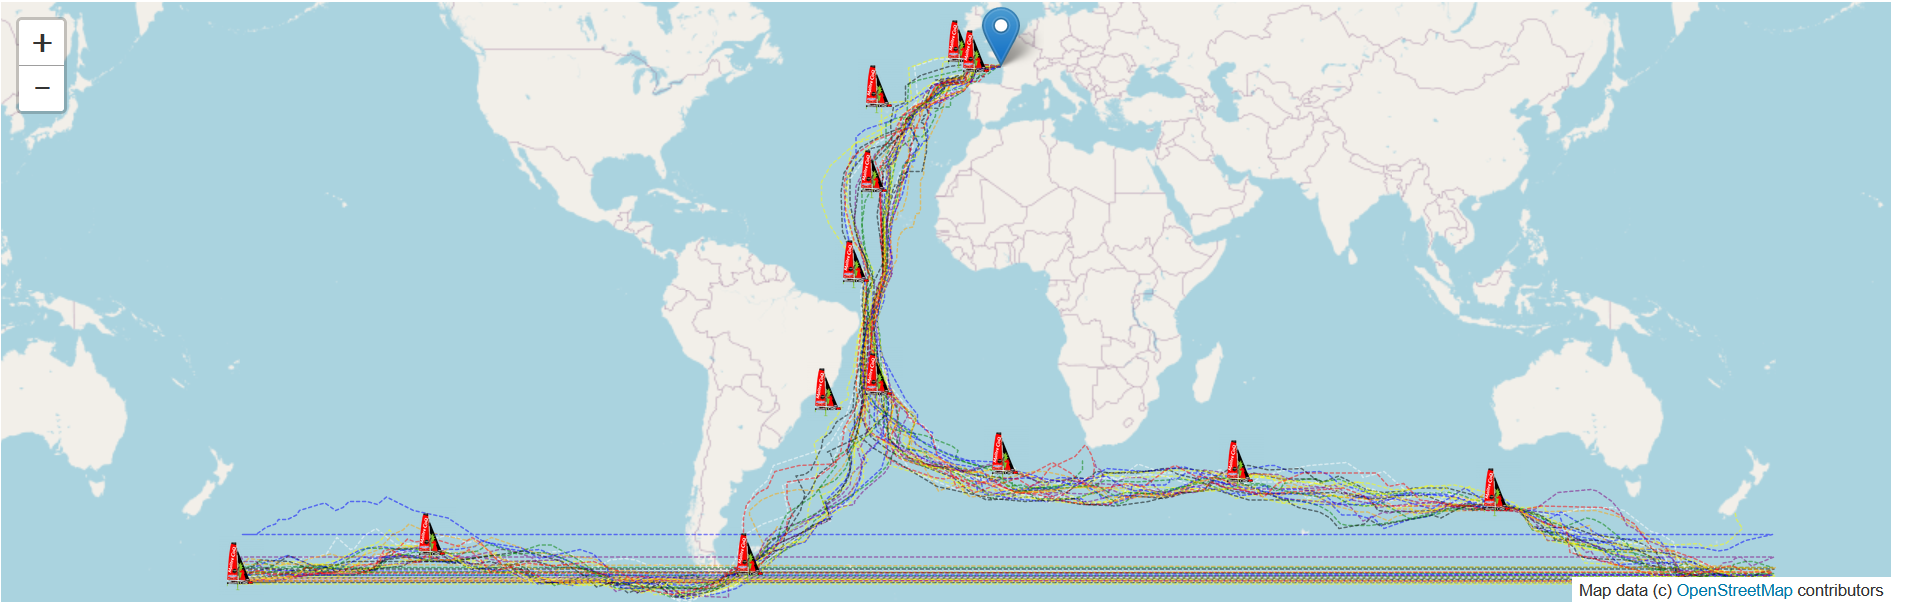

qu'en est t'il de la distance parcourue par voilier ...

,Skipper,Nat./Voile,Depuis le dernier classement - Distance
0,Alan Roura,SUI 7,26391.2


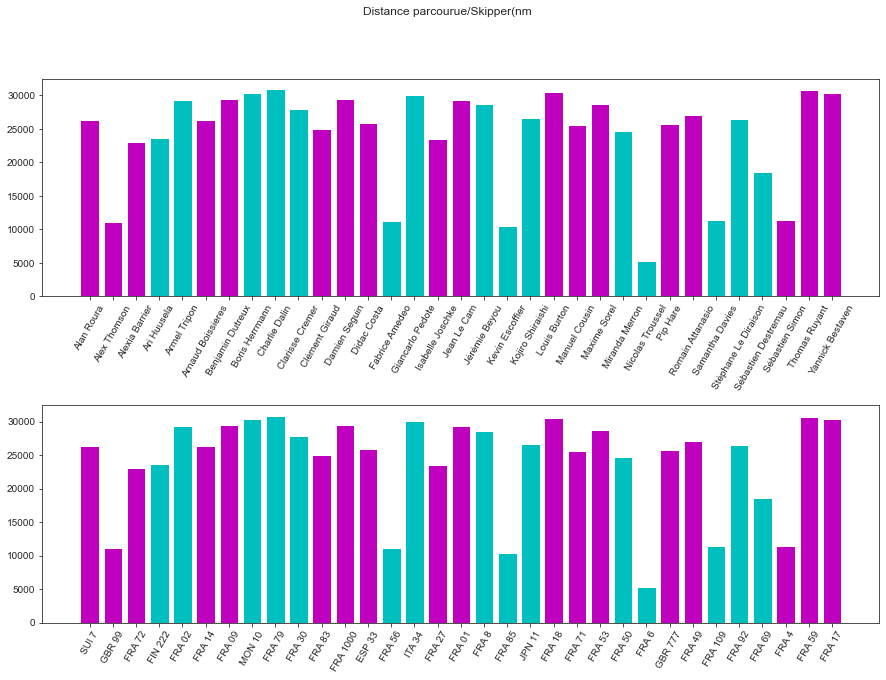

In [109]:
df_v =all_df[['Depuis le dernier classement - Distance','Skipper','Nat./Voile']].groupby(by=['Skipper','Nat./Voile'] , dropna=True).agg({'Depuis le dernier classement - Distance':'sum'})
df_v=df_v.reset_index()
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Distance parcourue/Skipper(nm')

[ax1, ax2] = fig.subplots(2, 1, sharey=True)
fig.subplots_adjust(hspace=0.5)  
ax1.bar(x=df_v['Skipper'], height=df_v['Depuis le dernier classement - Distance'], color=list('mmmccmmccc')); 
ax2.bar(x=df_v['Nat./Voile'], height=df_v['Depuis le dernier classement - Distance'], color=list('mmmccmmccc')); 
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=60)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=60)
df_v.head(1)